# Using the sampler

`hlm_gibbs` is a generic gibbs sampling framework for spatially-correlated variance components models. The current supported models are:

- `hlm.both` contains specifications with correlated errors in both levels, with the first statement `se/sma` describing the lower level and the second statement `se/sma` describing the upper level. In addition, `MVCM`, the multilevel variance components model with no spatial correlation, is in the `both` namespace. 
- `hlm.lower` contains two specifications, `se/sma`, that can be used for a variance components model with correlated lower-level errors.
- `hlm.upper` contains two specifications, `se/sma` that can be used for a variance components model with correlated upper-level errors. 

In [1]:
import hlm
hlm.both.Generic # abstract customizable class, ignores rho/lambda, equivalent to MVCM
hlm.both.MVCM # no spatial effect
hlm.both.SESE #  both spatial error (SE)
hlm.both.SESMA # lower-level SE, upper-level spatial moving average
hlm.both.SMASE # lower-level SMA, upper-level SE
hlm.both.SMASMA # both levels SMA
hlm.upper.SE # lower-level uncorrelated, upper-level SE
hlm.upper.SMA # lower-level uncorrelated, upper-level SMA
hlm.lower.SE # lower-level SE, upper-level uncorrelated
hlm.lower.SMA # lower-level SMA, upper-level uncorrelated 

hlm/abstracts.py:9: UserWarning: The `dill` module is required to use the sqlite backend and was not found.
  from .sqlite import head_to_sql, start_sql


hlm.lower_level.sma.model.Lower_SMA

Depending on the structure of the model, you need at least:
- `X`, data at the lower level
- `Y`, system response in the lower level
- `membership` or `Delta`, the membership vector relating each observation to its group or the "dummy variable" matrix encoding the same information. 

Then, if spatial correlation is desired, `M` is the "upper-level" weights matrix and `W` the lower-level weights matrix. 

Finally, there are many configuration and tuning options that can be passed in at the start, or assigned after the model is initialized. 

First, though, let's set up some data for a model on southern counties relating `DNL90` to `GI89`, `BLK90`, and `HR90`, with statewide average `FH90` as an upper-level predictor. 

In [2]:
#seaborn is required for the traceplots
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

First, we'll will read in the data and assign to the correct response, upper-, and lower-level data. 

In [3]:
data = ps.pdio.read_files(ps.examples.get_path('south.shp'))
data = data[data.STATE_NAME != 'District of Columbia']
X = data[['GI89', 'BLK90', 'HR90']].values
N = X.shape[0]
Z = data.groupby('STATE_NAME')['FH90'].mean()
Z = Z.values.reshape(-1,1)
J = Z.shape[0]

Y = data.DNL90.values.reshape(-1,1)

Then, we'll construct some weights from the files. 

In [4]:
W2 = ps.queen_from_shapefile(ps.examples.get_path('us48.shp'), 
                             idVariable='STATE_NAME')
W2 = ps.w_subset(W2, ids=data.STATE_NAME.unique().tolist()) #only keep what's in the data
W1 = ps.queen_from_shapefile(ps.examples.get_path('south.shp'),
                             idVariable='FIPS')
W1 = ps.w_subset(W1, ids=data.FIPS.tolist()) #again, only keep what's in the data

W1.transform = 'r'
W2.transform = 'r'

With the data, upper-level weights, and lower-level weights, we can construct a membership vector *or* a dummy data matrix. For now, I'll create the membership vector.

In [5]:
membership = data.STATE_NAME.apply(lambda x: W2.id_order.index(x)).values

But, we could also build the dummy variable matrix using `pandas`, if we have a suitable categorical variable:

In [6]:
Delta_frame = pd.get_dummies(data.STATE_NAME)
Delta = Delta_frame.values

Every call to the sampler is of the following form:

`sampler(Y, X, W, M, Z, membership, Delta, n_samples, **configuration)`

Where `W`, `M` are passed if appropriate, `Z` is passed if used, and only one of `membership` or `Delta` is required. In the end, `Z` is appended to `X`, so the effects pertaining to the upper level will be at the tail end of the $\beta$ effects vector. If both `Delta` and `membership` are supplied, they're verified against each other to ensure that they agree before they are used in the model. 

Every sampler uses, either in whole or in part, `hlm.both.generic`, which implements the full generic sampler discussed in the working paper. For efficiency, the upper-level samplers modify this runtime to avoid processing the full lower-level covariance matrix. 

Like many of the `R` packages dedicated to bayesian models, configuration occurs by passing the correct dictionary to the model call. In addition, you can "setup" the model, configure it, and then run samples in separate steps. 

The most common way to call the sampler is something like:

In [7]:
vcsma = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                      n_samples=5000,
                      configs=dict(tuning=1000, adapt_step=1.01))

In [8]:
vcsma.trace.varnames

['Tau2', 'Alphas', 'Betas', 'Lambda', 'Sigma2']

For all models, the membership vector or an equivalent dummy variable matrix is required. For models with correlation in the upper level, only the upper-level weights matrix $\mathbf{M}$ is needed. For lower level models, the lower-level weights matrix $\mathbf{W}$ is required. For models with correlation in both levels, both $\mathbf{W}$ and $\mathbf{M}$ are required. 

The results and state of the sampler are stored within the `vcsma` object. I'll step through the most important parts of this object. 

# `trace`

The quickest way to get information out of the model is via the trace object. This is where the results of the tracked parameters are stored each iteration. Any variable in the sampler state can be added to the tracked params. Trace objects are essentially dictionaries with the keys being the name of the tracked parameter and the values being a list of each iteration's sampler output.

In [9]:
vcsma.trace.varnames

['Tau2', 'Alphas', 'Betas', 'Lambda', 'Sigma2']

In this case, `Lambda` is the upper-level moving average parameter, `Alphas` is the vector of correlated group-level random effects, `Tau2` is the upper-level variance, `Betas` are the marginal effects, and `Sigma2` is the lower-level error variance.

I'm working to rename these to be consistent with the draft naming convention, but am writing unittests first to make sure that the rename doesn't induce errors. 

I've written two helper functions for working with traces. First is to just dump all the output into a pandas dataframe, which makes it super easy to do work on the samples, or write them out to `csv` and assess convergence in R's `coda` package.

In [10]:
trace_dataframe = vcsma.trace.to_df()

In [11]:
trace_dataframe.mean()

Tau2          0.225674
Lambda        0.683944
Sigma2        1.276840
Alphas_0      0.327853
Alphas_1      0.716937
Alphas_2      0.756146
Alphas_3      0.450669
Alphas_4      0.402733
Alphas_5     -0.836657
Alphas_6      0.179398
Alphas_7      0.116327
Alphas_8     -0.730513
Alphas_9     -0.539021
Alphas_10    -0.109744
Alphas_11     0.030385
Alphas_12    -0.317806
Alphas_13    -0.327162
Alphas_14     0.168879
Alphas_15     0.115656
Betas_0       4.053715
Betas_1     -11.899510
Betas_2       0.003546
Betas_3       0.030316
Betas_4      -0.044734
dtype: float64

The second is a method to plot the traces:

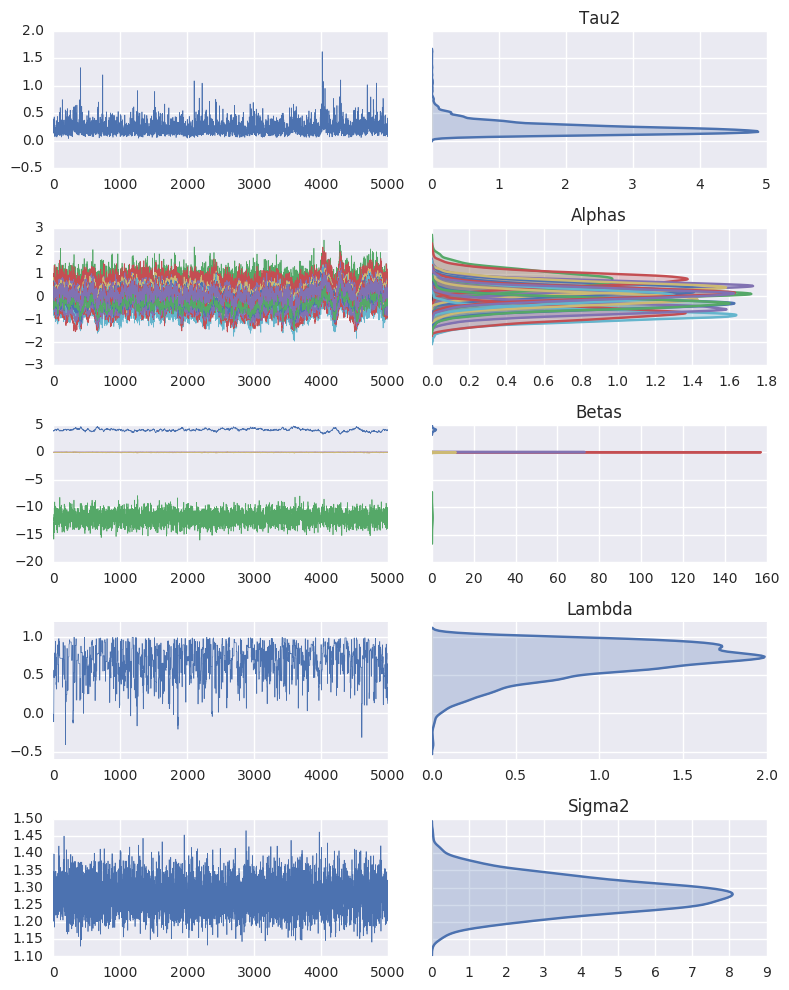

In [12]:
fig, ax = vcsma.trace.plot()
plt.tight_layout()
plt.show()

The trace object can be sliced by (chain, parameter, index) tuples, or any subset thereof. 

In [13]:
vcsma.trace['Lambda',-4:] #last 4 draws of lambda

array([ 0.34034592,  0.12757407,  0.12757407,  0.25197131])

In [14]:
vcsma.trace[['Tau2', 'Sigma2'], 0:2] #the first 2 variance parameters

{'Sigma2': [1.3467504491135562, 1.3062723215872214],
 'Tau2': [0.25273048751126681, 0.20915635932410312]}

We only ran a single chain, so the first index is assumed to be zero. You can run more than one chain in parallel, using the builtin python `multiprocessing` library:

In [15]:
vcsma_p = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=5000, n_jobs=3, #run 3 chains
                        configs=dict(tuning=500, adapt_step=1.01))

In [16]:
vcsma_p.trace[0, 'Betas', -1] #the last draw of Beta on the first chain. 

array([[  4.05471390e+00],
       [ -1.18761697e+01],
       [  3.84750722e-03],
       [  2.43061215e-02],
       [ -1.08017002e-02]])

In [17]:
vcsma_p.trace[1, 'Betas', -1] #the last draw of Beta on the second chain

array([[  4.01774750e+00],
       [ -1.24632809e+01],
       [  5.47436941e-03],
       [  2.69948314e-02],
       [  3.74327351e-02]])

and the chain plotting works also for the multi-chain traces:

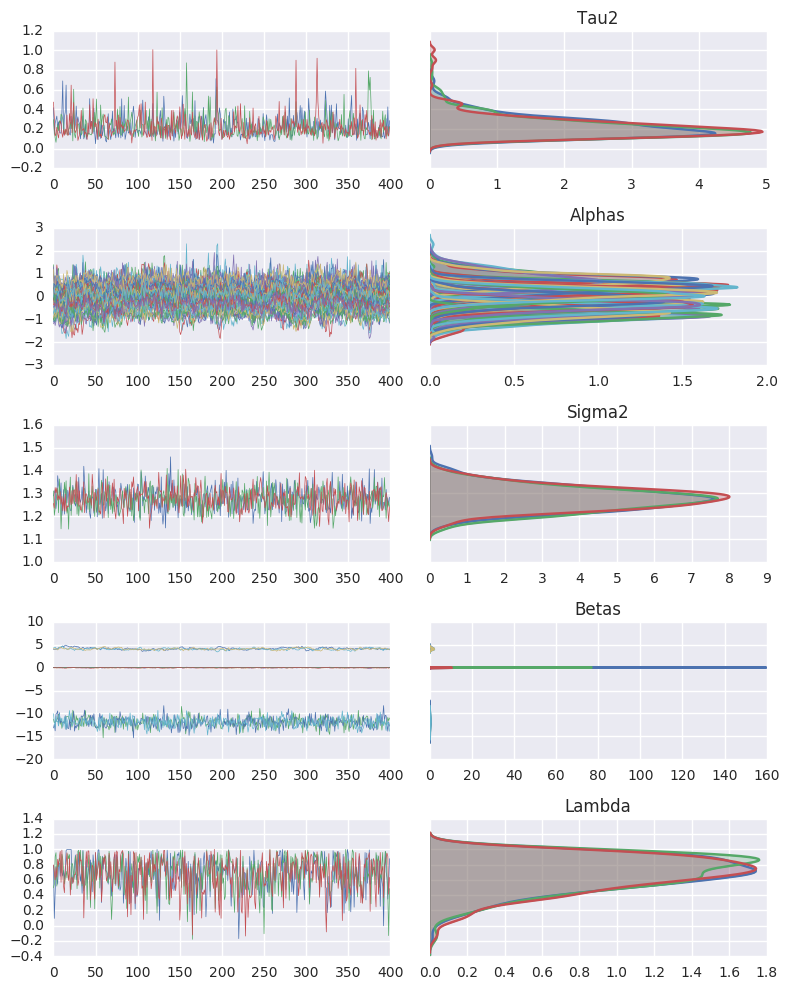

In [18]:
vcsma_p.trace.plot(burn=1000, thin=10) #there are quite a few plot options
plt.show()

To get stuff like posterior quantiles, you can use the attendant pandas dataframe functionality, like `describe`. 

In [19]:
df = vcsma.trace.to_df()

In [20]:
df.describe()

,Tau2,Lambda,Sigma2,Alphas_0,Alphas_1,Alphas_2,Alphas_3,Alphas_4,Alphas_5,Alphas_6,...,Alphas_11,Alphas_12,Alphas_13,Alphas_14,Alphas_15,Betas_0,Betas_1,Betas_2,Betas_3,Betas_4
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.225674,0.683944,1.276840,0.327853,0.716937,0.756146,0.450669,0.402733,-0.836657,0.179398,...,0.030385,-0.317806,-0.327162,0.168879,0.115656,4.053715,-11.899510,0.003546,0.030316,-0.044734
std,0.115663,0.217482,0.047989,0.276857,0.412040,0.294096,0.249365,0.267934,0.258226,0.285528,...,0.301791,0.257396,0.266504,0.261551,0.261829,0.230376,1.119311,0.002584,0.005220,0.034627
min,0.041840,-0.408330,1.129385,-0.583244,-0.928741,-0.316809,-0.480813,-0.394040,-1.945146,-0.753424,...,-0.875959,-1.201916,-1.487485,-0.803750,-0.913978,3.280553,-15.970898,-0.005482,0.010610,-0.175362
25%,0.149289,0.564979,1.243471,0.142066,0.440965,0.560008,0.290002,0.222046,-0.995070,-0.015819,...,-0.173077,-0.481146,-0.492163,0.003178,-0.049866,3.910126,-12.656403,0.001863,0.026772,-0.067677
50%,0.200740,0.720837,1.275781,0.325393,0.709047,0.751082,0.451593,0.396942,-0.829096,0.176704,...,0.027631,-0.314713,-0.318264,0.166105,0.119258,4.061062,-11.901190,0.003563,0.030256,-0.044310
75%,0.270936,0.854245,1.307782,0.505824,0.979722,0.938586,0.607493,0.570925,-0.671065,0.364157,...,0.226421,-0.150378,-0.155768,0.334379,0.283713,4.192664,-11.151888,0.005265,0.033854,-0.021803
max,1.618948,0.996117,1.465318,1.354983,2.460238,2.156808,1.517094,1.379884,0.172266,1.301474,...,1.385359,0.854821,0.768022,1.230431,1.130611,4.764463,-7.888839,0.012909,0.048657,0.081625


There is also a `trace.summarize` function that will compute various things contained in `hlm.diagnostics` on the chain. It takes a while for large chains, because the `statsmodels.tsa.AR` estimator is much slower than the `ar` estimator in `R`. If you have rpy2 installed *and* `CODA` installed in your R environment, I attempt to use R directly. 

In [21]:
vcsma.trace.summarize()

mean    HPD_low     median  HPD_high       std  \
Chain_0 Tau2        0.225674   0.061673   0.200740  0.447639  0.115663   
        Lambda      0.683944   0.258867   0.720837  0.996117  0.217482   
        Sigma2      1.276840   1.182938   1.275781  1.369346  0.047989   
        Alphas_0    0.327853  -0.206645   0.325393  0.885398  0.276857   
        Alphas_1    0.716937  -0.059296   0.709047  1.567001  0.412040   
        Alphas_2    0.756146   0.175378   0.751082  1.329398  0.294096   
        Alphas_3    0.450669  -0.078318   0.451593  0.921391  0.249365   
        Alphas_4    0.402733  -0.131063   0.396942  0.928422  0.267934   
        Alphas_5   -0.836657  -1.360396  -0.829096 -0.323748  0.258226   
        Alphas_6    0.179398  -0.376702   0.176704  0.765520  0.285528   
        Alphas_7    0.116327  -0.379276   0.117201  0.647217  0.252115   
        Alphas_8   -0.730513  -1.348977  -0.729976 -0.147144  0.308665   
        Alphas_9   -0.539021  -1.043543  -0.540135 -0.008305  0.258755   
        Alphas_10  -0.109744  -0.688883  -0.111561  0.447949  0.287240   
        Alphas_11   0.030385  -0.562033   0.027631  0.625118  0.301791   
        Alphas_12  -0.317806  -0.833873  -0.314713  0.192264  0.257396   
        Alphas_13  -0.327162  -0.888292  -0.318264  0.158795  0.266504   
        Alphas_14   0.168879  -0.378432   0.166105  0.675642  0.261551   
        Alphas_15   0.115656  -0.410934   0.119258  0.639923  0.261829   
        Betas_0     4.053715   3.604779   4.061062  4.530870  0.230376   
        Betas_1   -11.899510 -14.080105 -11.901190 -9.740106  1.119311   
        Betas_2     0.003546  -0.001525   0.003563  0.008613  0.002584   
        Betas_3     0.030316   0.020821   0.030256  0.041022  0.005220   
        Betas_4    -0.044734  -0.117054  -0.044310  0.019016  0.034627   

                   N_iters  N_effective  AR_loss  
Chain_0 Tau2          5000        722.0   0.8556  
        Lambda        5000        587.0   0.8826  
        Sigma2        5000       5132.0  -0.0264  
        Alphas_0      5000         64.0   0.9872  
        Alphas_1      5000        427.0   0.9146  
        Alphas_2      5000         86.0   0.9828  
        Alphas_3      5000         58.0   0.9884  
        Alphas_4      5000         51.0   0.9898  
        Alphas_5      5000         96.0   0.9808  
        Alphas_6      5000         53.0   0.9894  
        Alphas_7      5000         62.0   0.9876  
        Alphas_8      5000         65.0   0.9870  
        Alphas_9      5000         58.0   0.9884  
        Alphas_10     5000        129.0   0.9742  
        Alphas_11     5000         63.0   0.9874  
        Alphas_12     5000         79.0   0.9842  
        Alphas_13     5000        106.0   0.9788  
        Alphas_14     5000         63.0   0.9874  
        Alphas_15     5000         84.0   0.9832  
        Betas_0       5000         41.0   0.9918  
        Betas_1       5000       3187.0   0.3626  
        Betas_2       5000       2970.0   0.4060  
        Betas_3       5000       4213.0   0.1574  
        Betas_4       5000        183.0   0.9634

So, 5000 iterations, but only ~ 500 draws of the spatial parameter. 

The existing python packages for MCMC diagnostics were incorrect. So, I've implemented many of the diagnostics from `CODA`, and have verified that the diagnostics comport with `CODA` diagnostics. One can also use `numpy` & `statsmodels` functions. I'll show some types of analysis.

In [22]:
from statsmodels.api import tsa
#if you don't have it, try removing the comment and:
#! pip install statsmodels

For example, a plot of the partial autocorrelation in $\lambda$, the upper-level spatial moving average parameter, over the last half of the chain is:

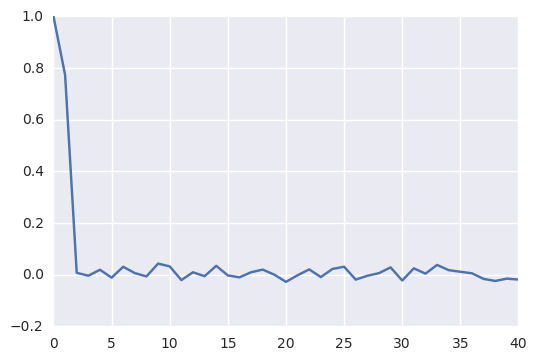

In [23]:
plt.plot(tsa.pacf(vcsma.trace['Lambda', -2500:]))

So, the chain is close-to-first order:

In [24]:
tsa.pacf(df.Lambda)[0:3]

array([ 1.        ,  0.78987066,  0.01620438])

We could do this for many parameters, too. An Autocorrelation/Partial Autocorrelation plot can be made of the marginal effects by:

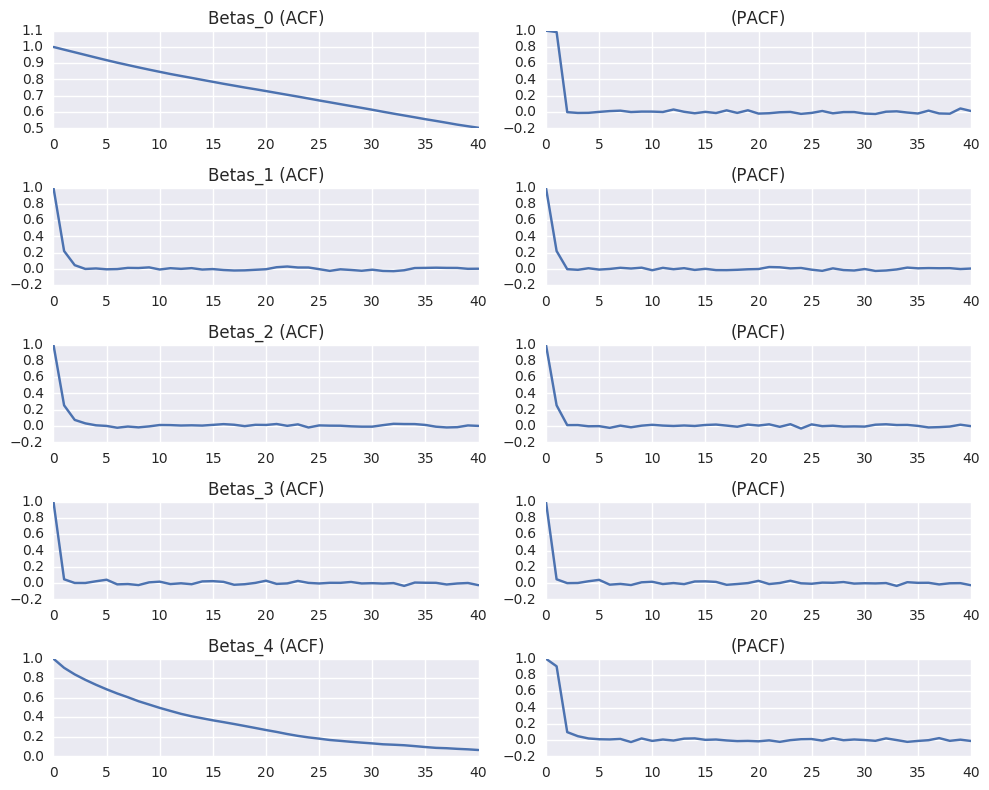

In [25]:
betas = [c for c in df.columns if c.startswith('Beta')]
f,ax = plt.subplots(len(betas), 2, figsize=(10,8))
for i, col in enumerate(betas):
    ax[i,0].plot(tsa.acf(df[col].values))
    ax[i,1].plot(tsa.pacf(df[col].values)) #the pacf plots take a while
    ax[i,0].set_title(col +' (ACF)')
    ax[i,1].set_title('(PACF)')
f.tight_layout()
plt.show()

As far as the builtin diagnostics for convergence and simulation quality, the `diagnostics` module exposes a few things:

In [26]:
from hlm import diagnostics as diag

Geweke statistics for differences in means between chain components:

In [27]:
gstats = diag.geweke(vcsma, varnames='Lambda') #takes a while
print(gstats)

[{'Lambda': array([ -1.81928157e+00,  -1.73495645e+00,  -1.79080972e+00,
        -1.98552747e+00,  -1.28055151e+00,  -8.35173698e-01,
        -6.16713733e-01,  -5.37410462e-01,  -3.21719931e-01,
         1.34841022e-01,   1.79447764e-01,  -1.27887054e-02,
        -1.17696975e-01,   4.65483550e-02,  -8.14010328e-01,
        -1.35590103e+00,  -1.60543274e+00,  -1.86877017e+00,
        -2.09115538e+00,  -2.45973889e+00,  -2.09900451e+00,
        -2.05053136e+00,  -2.13106626e+00,  -2.22145420e+00,
        -2.99595651e+00,  -2.85518266e+00,  -2.96437160e+00,
        -2.70057516e+00,  -2.09457680e+00,  -1.92380140e+00,
        -2.03046029e+00,  -1.65308515e+00,  -7.24090414e-01,
        -3.25056620e-01,  -1.73382326e-01,   4.53647802e-01,
         3.68245188e-01,   3.73463778e-01,   2.58753936e-03,
        -9.42595476e-01,  -3.23419853e-01,  -7.26327968e-01,
        -5.58010616e-01,  -4.90452694e-01,  -3.26823740e-01,
         6.14372789e-02,  -4.93757507e-01,  -4.02024824e-01,
        -1.1

Typically, this means the chain is converged at the given "bin" count if the line stays within $\pm2$. The geweke statistic is a test of differences in means between the given chunk of the chain and the remaining chain. If it's outside of +/- 2 in the early part of the chain, you should discard observations early in the chain.

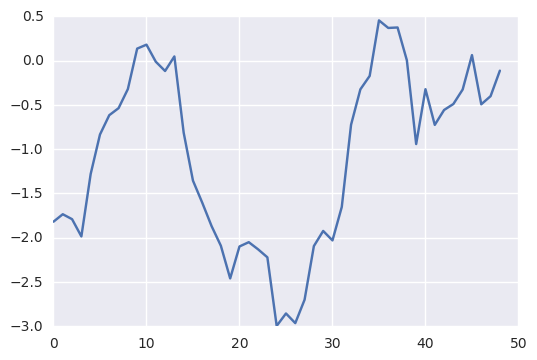

In [28]:
plt.plot(gstats[0]['Lambda'][:-1])

We can also compute Monte Carlo Standard Errors like in the `mcse` R package, which represent the intrinsic error contained in the estimate:

In [29]:
diag.mcse(vcsma, varnames=['Tau2', 'Sigma2'])

{'Sigma2': 0.00062601204914912933, 'Tau2': 0.0041465338956788783}

Another handy statistic is the Partial Scale Reduction factor, which measures of how likely a set of chains run in parallel have converged to the same stationary distribution. It provides the difference in variance between between chains vs. within chains. 

If these are significantly larger than one (say, 1.5), the chain probably has not converged. Being marginally below $1$ is fine, too.

In [30]:
diag.psrf(vcsma_p, varnames=['Tau2', 'Sigma2'])

{'Sigma2': 0.99989888741989108, 'Tau2': 1.0028049426401897}

Highest posterior density intervals provide a kind of interval estimate for parameters in Bayesian models:

In [31]:
diag.hpd_interval(vcsma, varnames=['Betas', 'Lambda', 'Sigma2'])

{'Betas': [(3.6047785574409379, 4.5308697431085792),
  (-14.080105436981922, -9.7401063518521696),
  (-0.0015251694482754053, 0.0086130635774684695),
  (0.020820526504271679, 0.04102186529269642),
  (-0.11705432783473835, 0.019016303210805267)],
 'Lambda': (0.25886743069381157, 0.99611686016790413),
 'Sigma2': (1.1829380842609549, 1.3693460045635377)}

Sometimes, you want to apply arbitrary functions to each parameter trace. To do this, I've written a `map` function that works like the python builtin `map`. For example, if you wanted to get arbitrary percentiles from the chain:

In [32]:
vcsma.trace.map(np.percentile, 
                varnames=['Lambda', 'Tau2', 'Sigma2'],
                #arguments to pass to the function go last
                q=[25, 50, 75]) 

[{'Lambda': array([ 0.56497898,  0.72083721,  0.8542454 ]),
  'Sigma2': array([ 1.2434706 ,  1.27578126,  1.30778201]),
  'Tau2': array([ 0.14928906,  0.20073954,  0.27093587])}]

In addition, you can pop the trace results pretty simply to a `.csv` file and analyze it elsewhere, like if you want to use use the `coda` Bayesian Diagnostics package in `R`. 

To write out a model to a csv, you can use:

In [33]:
vcsma.trace.to_csv('./model_run.csv')

And, you can even load traces from csvs:

In [34]:
from hlm.abstracts import Trace

['Tau2', 'Alphas', 'Sigma2', 'Betas', 'Lambda']


(<matplotlib.figure.Figure at 0x7fe1be306cd0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1bdeeba90>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7fe1bc02f1d0>]], dtype=object))

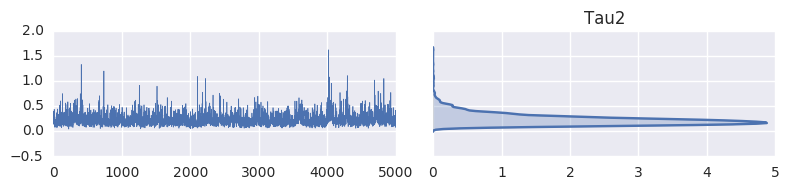

In [35]:
tr = Trace.from_csv('./model_run.csv')
print(tr.varnames)
tr.plot(varnames=['Tau2'])

#  Working with models: `draw` and `sample`

These two functions are used to call the underlying Gibbs sampler. They take no arguments, and operate on the sampler in place. `draw` provides a single new sample:

In [36]:
vcsma.draw()

And sample steps forward an arbitrary number of times:

In [37]:
vcsma.sample(10)

At this point, we did 5000 initial samples and 11 extra samples. Thus:

In [38]:
vcsma.cycles

5011

Parallel models can suspend/resume sampling too:

In [39]:
vcsma_p.sample(10)

In [40]:
vcsma_p.cycles

5010

Under the hood, it's the `draw` method that actually ends up calling one run of `model._iteration`, which is where the actual statistical code lives. Then, it updates all `model.traced_params` by adding their current value in `model.state` to `model.trace.` In addition, `model._finalize` is called the first time sampling is run, which computes some of the constants & derived quantities that save computing time.

# Working with models:  `state`

This is the collection of current values in the sampler. To be efficient, Gibbs sampling must keep around some of the computations used in the simulation, since sometimes the same terms show up in different conditional posteriors. So, the current values of the sampler are stored in `state`.

All of the following are tracked in the state:

In [41]:
print(vcsma.state.keys())

['Sigma2_b0', 'Lambda_max', 'W', 'PsiLambdai', 'Psi_1i', 'Betas_covm', 'Tau2', 'PsiRhoi', 'DeltaAlphas', 'Log_Lambda0', 'XtX', 'Rho_min', 'Tau2_an', 'Tau2_a0', 'Rho', 'Delta', 'Alphas', 'Psi_2i', 'initial_values', 'XBetas', 'Psi_1', 'Psi_2', 'J', 'M', 'Rho_max', 'Sigma2_a0', 'N', 'Betas_cov0', 'Betas', 'Tau2_b0', 'Y', 'X', 'Lambda', 'Sigma2_an', 'Betas_mean0', 'Log_Rho0', 'Lambda_min', 'p', 'Ij', 'In', 'DeltatDelta', 'Betas_cov0i', 'Sigma2']


If you want to track how something (maybe a hyperparameter) changes over sampling, you can pass `extra_traced_params` to the model declaration:

In [42]:
example = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=250, 
                        extra_traced_params = ['DeltaAlphas'],
                        configs=dict(tuning=500, adapt_step=1.01))
example.trace.varnames

['Tau2', 'Alphas', 'Betas', 'DeltaAlphas', 'Lambda', 'Sigma2']

# `configs`
this is where configuration options for the various MCMC steps are stored. For multilevel variance components models, these are called $\rho$ for the lower-level error parameter and $\lamdba$ for the upper-level parameter. Two exact sampling methods are implemented, Metropolis sampling & Slice sampling. 

Each MCMC step has its own config:

In [43]:
vcsma.configs

{'Lambda': <hlm.steps.Metropolis at 0x7fe1ca664d50>,
 'Rho': <hlm.steps.Metropolis at 0x7fe1ca664f90>}

Since `vcsma` is an upper-level-only model, the `Rho` config is skipped. But, we can look at the `Lambda` config. The number of accepted `lambda` draws is contained in :

In [44]:
vcsma.configs.Lambda.accepted

1464

so, the acceptance rate is

In [45]:
vcsma.configs.Lambda.accepted / float(vcsma.cycles)

0.29215725404110954

Also, if you want to get verbose output from the metropolis sampler, there is a "debug" flag:

In [46]:
example = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=500, 
                        configs=dict(tuning=250, adapt_step=1.01, 
                                     debug=True))

Which stores the information about each iteration in a list, accessible from `model.configs.<parameter>._cache`:

In [47]:
example.configs.Lambda._cache[-1] #let's only look at the last one

{'accepted': False,
 'current_logp': array([-10.12795513]),
 'jump': 2.432587304029994,
 'new_logp': array([-10.12795513])}

Configuration of the MCMC steps is done using the `config` options dictionary, like done in `spBayes` in `R`. The actual configuration classes exist in hlm.steps:

In [48]:
from hlm.steps import Metropolis, Slice

Most of the common options are:

### Metropolis 
- `jump`: the starting standard deviation of the proposal distribution
- `tuning`: the number of iterations to tune the scale of the proposal
- `ar_low`: the lower bound of the target acceptance rate range
- `ar_hi`: the upper bound of the target acceptance rate range
- `adapt_step`: a number (bigger than 1) that will be used to modify the jump in order to keep the acceptance rate betwen `ar_lo` and `ar_hi`. Values much larger than `1` result in much more dramatic tuning. 

### Slice
- `width`: starting width of the level set
- `adapt`: number of previous slices use in the weighted average for the next slice. If `0`, the `width` is not dynamically tuned. 

In [49]:
example = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=500, 
                        configs=dict(tuning=250, adapt_step=1.01, 
                                     debug=True, ar_low=.1, ar_hi=.4))

In [50]:
example.configs.Lambda.ar_hi, example.configs.Lambda.ar_low

(0.4, 0.1)

In [51]:
example_slicer = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                               n_samples=500, 
                               configs=dict(Lambda_method='slice'))

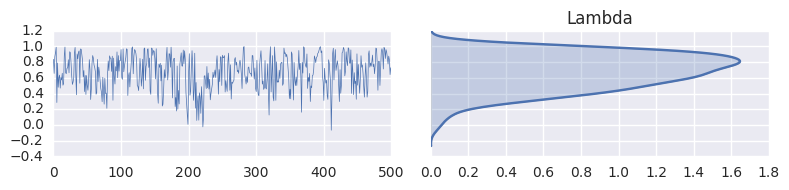

In [52]:
example_slicer.trace.plot(varnames='Lambda')
plt.show()

In [53]:
example_slicer.configs.Lambda.adapt, example_slicer.configs.Lambda.width

(0, 0.5)

# Working with models: customization

If you're doing heavy customization, it makes the most sense to first initialize the class without sampling. We did this before when showing how the "extra_traced_params" option worked. 

To show, let's initialize a double-level SAR-Error variance components model, but not actually draw anything.

To do this, you pass the option `n_samples=0`.

In [54]:
vcsese = hlm.both.SESE(Y, X, W=W1, M=W2, Z=Z, membership=membership, 
                      n_samples=0)

This sets up a two-level spatial error model with the default uninformative configuration. This means the prior precisions are all `I * .001*`, prior means are all 0, spatial parameters are set to `-1/(n-1)`, and prior scale factors are set arbitrarily. 

### Configs

Options are set by assgning to the relevant property in `model.configs`. 

The model configuration object is another dictionary with a few special methods. 

Configuration options are stored for each parameter separately:

In [55]:
vcsese.configs

{'Lambda': <hlm.steps.Metropolis at 0x7fe19caeead0>,
 'Rho': <hlm.steps.Metropolis at 0x7fe19caeef10>}

So, for example, if we wanted to turn off adaptation in the upper-level parameter, and fix the Metrpolis jump variance to `.25`:

In [56]:
vcsese.configs.Lambda.max_tuning = 0
vcsese.configs.Lambda.jump  = .25

### Priors

Another thing that might be interesting (though not "bayesian") would be to fix the prior mean of $\beta$ to the OLS estimates. One way this could be done would be to pull the `Delta` matrix out from the state, and estimate:
$$ Y = X\beta + \Delta Z + \epsilon $$
using `PySAL`: 

In [57]:
Delta = vcsese.state.Delta
DeltaZ = Delta.dot(Z)
vcsese.state.Betas_mean0 = ps.spreg.OLS(Y, np.hstack((X, DeltaZ))).betas

### Starting Values

If you wanted to start the sampler at a given starting value, you can do so by assigning that value to the `Lambda` value in `state`. 

In [58]:
vcsese.state.Lambda = -.25

Sometimes, it's suggested that you start the beta vector randomly, rather than at zero. For the parallel sampling, the model starting values are adjusted to induce overdispersion in the start values. 

You could do this manually, too:

In [59]:
vcsese.state.Betas += np.random.uniform(-10, 10, size=(vcsese.state.p,1))

### Spatial Priors

Changing the spatial parameter priors is also done by changing their prior in state. This prior must be a function that takes a value of the parameter and return the log of the prior probability for that value. 

For example, we could assign `P(\lambda) = Beta(2,1)` and zero if outside $(0,1)$, and asign $\rho$ a truncated $\mathcal{N}(0,.5)$ prior by first defining their functional form:

In [60]:
from scipy import stats

In [61]:
def Lambda_prior(val):
    if (val < 0) or (val > 1):
        return -np.inf
    return np.log(stats.beta.pdf(val, 2,1))

In [62]:
def Rho_prior(val):
    if (val > .5) or (val < -.5):
        return -np.inf
    return np.log(stats.truncnorm.pdf(val, -.5, .5, loc=0, scale=.5))

And then assigning to their symbols, `LogLambda0` and `LogRho0` in the state:

In [63]:
vcsese.state.LogLambda0 = Lambda_prior
vcsese.state.LogRho0 = Rho_prior

### Performance

The efficiency of the sampler is contingent on the lower-level size. If we were to estimate the draw in a dual-level SAR-Error Variance Components iteration:

In [64]:
%timeit vcsese.draw()

10 loops, best of 3: 44.5 ms per loop


To make it easy to work with the model, you can interrupt and resume sampling using keyboard interrupts (`ctrl-c` or the `stop` button in the notebook). 

In [65]:
%time vcsese.sample(100)

CPU times: user 7.96 s, sys: 160 ms, total: 8.12 s
Wall time: 4.2 s


In [66]:
vcsese.sample(10)

# Under the Hood

### Package Structure

Most of the tools in the package are stored in relevant python files in the top level or a dedicated subfolder. Explaining a few:

- `abstracts.py` - the abstract class machinery to iterate over a sampling loop. This is where the classes are defined, like `Trace`, `Sampler_Mixin`, or `Hashmap`. 
- `plotting.py` - tools for plotting output
- `steps.py` - the step method definitions
- `verify.py` - like `user` checks in `pysal.spreg`, this contains a few sanity checks. 
- `utils.py`- contains statistical or numerical utilities to make the computation easier, like cholesky multivariate normal sampling, more sparse utility functions, etc. 
- `diagnostics.py` - all the diagnostics
- `priors.py` - definitions of alternative prior forms. Right now, this is pretty simple. 
- `sqlite.py` - functions to use a sqlite database instead of an in-memory chain are defined here. 

### The implementation of a Model

The package is implemented so that every "model type" first sends off to the `hlm.both.Base_Generic`, which sets up the state, trace, and priors. 

Models are added by writing a `model.py` file and possibly a `sample.py` file. The `model.py` file defines a `Base/User` class pair (like `spreg`) that sets up the state and trace. It must define hyperparameters, and can precompute objects used in the sampling loop. The base class should inherit from `Sampler_Mixin`, which defines all of the machinery of sampling. 

The loop through the conditional posteriors should be defined in `model.py`, in the `model._iteration` function. This should update the model state in place.

The model may also define a `_finalize` function which is run once before sampling. 

So, if I write a new model, like a varying-intercept model with endogenously-lagged intercepts, I would write a `model.py` containing something like:
```python

class Base_VISAR(hlm.generic.Base_Generic):
    def __init__(self, Y, X, M, membership=None, Delta=None,
                 extra_traced_params=None, #record extra things in state
                 n_samples=1000, n_jobs=1, #sampling config
                 priors = None, # dict with prior values for params
                 configs=None, # dict with configs for MCMC steps
                 starting_values=None, # dict with starting values
                 truncation=None, # options to truncate MCMC step priors
                 center=True, # Whether to center the X,Z matrices
                 scale=False # Whether re-scale the X,Z matrices
                 ):
        super(Base_VISAR, self).__init__(self, Y, X, M, W=None,
                                         membership=membership,
                                         Delta=Delta,
                                         n_samples=0, n_jobs=n_jobs,
                                         priors=priors, configs=configs,
                                         starting_values=starting_values,
                                         truncation=truncation,
                                         center=center,
                                         scale=scale
                                         )
        self.sample(n_samples, n_jobs=n_jobs)
        
        def _finalize(self):
            # the degrees of freedom of the variance parameter is constant
            self.state.Sigma2_an = self.state.N/2 + self.state.Sigma2_a0
            ...
        
        def _iteration(self):
            
            # computing the values needed to sample from the conditional posteriors
            mean = spdot(X.T, spdot(self.PsiRhoi, X)) / Sigma2 + self.state.bmean0
            ...
    ...
```
I've organized the directories in this project into `both_levels`, `upper_level`, `lower_level`, and `hierarchical`, which contains some of the spatially-varying coefficient models & other models I'm working on that are unrelated to the multilevel variance components stuff. 

Since most of the `_iteration` loop is the same between models, most of the models share the same sampling code, but customize the structure of the covariance in each level. These covariance variables are stored in the `state.Psi_1`, for the lower-level covariance, and `state.Psi_2` for the upper-level covariance. Likewise, the precision functions are `state.Psi_1i` and `state.Psi_2i`. 

For example:

In [67]:
vcsese.state.Psi_1 #lower-level covariance

<function hlm.utils.se_covariance>

In [68]:
vcsese.state.Psi_2 #upper-level covariance

<function hlm.utils.se_covariance>

In [69]:
vcsma.state.Psi_2 #upper-level covariance

<function hlm.utils.sma_covariance>

In [70]:
vcsma.state.Psi_2i

<function hlm.utils.sma_precision>

In [71]:
vcsma.state.Psi_1

<function hlm.utils.ind_covariance>

The functions that generate the covariance matrices are stored in `hlm.utils`. They can be arbitrarily overwritten for alternative covariance specifications. 

Thus, if we want to sample a model with a new covariance specification, then we need to define functions for the variance and precision.